## Tarea 1 - Beer Clustering
### Reconocimiento de patrones en Minería de Datos

Para esta tarea se realizara la implementación de los algoritmos de clustering: *K-means, Minibatch K-means, HAC Complete, DBSCAN* para el análisis de las reseñas obtenidos de la página beeradvocate la cual consta de un poco más de un millón y medio de datos como el dataset de prueba de los algoritmos, en los cuales se estudiara los valores de entrada de cada uno para obtener los clusters más adecuados.

# Caracterización del dataset
El data set consta de 13 atributos los cuales son:

<table class="tg">
  <tr>
    <th class="tg-yw4l">Nombre atributo</th>
    <th class="tg-yw4l">Tipo<br></th>
  </tr>
  <tr>
    <td class="tg-yw4l">brewery_id</td>
    <td class="tg-yw4l">int64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">brewery_name</td>
    <td class="tg-yw4l">object</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_time</td>
    <td class="tg-yw4l">int64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_overall</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_aroma</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_appearance</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_profilename</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_style</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_palate</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">review_taste</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_name</td>
    <td class="tg-yw4l">object </td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_abv</td>
    <td class="tg-yw4l">float64</td>
  </tr>
  <tr>
    <td class="tg-yw4l">beer_beerid</td>
    <td class="tg-yw4l">int64</td>
  </tr>
</table>


De los cuales como beer_name y beer_beerid con brewery_id y brewery_name son equivalentes entre si y son del tipo de atributo que sirven para etiquetar. Con lo que la dim real del dataset puede ser reducida a 11 atributos que son representativo en aspectos de calificativos, temporales y la tendencia de quien lo calificó.
Lo que implica que para los algoritmos [K-means, MiniBatch K-menas] que funcionan directamente sobre datos categoricos, por varias razones, el espacio muestral de los datos categoricos es discreto, y no tiene un origen natural. La función de distancia Euclidiana en este espacio no tiene un significado de peso. Dicho esto para realizar los cluster en el caso de [k means] se descartaran estos datos de tipo categorico en el análisis.

In [2]:
import numpy as np
import pandas as pn
import scipy
from sklearn import manifold
import matplotlib.pyplot as plt
import sklearn

beer_reviews  = pn.read_csv('beer_reviews/beer_reviews.csv',na_values=[''])[:500]
beer_reviews = beer_reviews.fillna(method='ffill')
#beer_red = manifold.SpectralEmbedding(n_components=2).fit_transform(beer_reviews)
print(beer_reviews.isnull().any())
print (beer_reviews.columns)
print (beer_reviews.shape)

brewery_id            False
brewery_name          False
review_time           False
review_overall        False
review_aroma          False
review_appearance     False
review_profilename    False
beer_style            False
review_palate         False
review_taste          False
beer_name             False
beer_abv              False
beer_beerid           False
dtype: bool
Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')
(500, 13)


In [3]:
from sklearn import preprocessing
#print (beer_reviews.dtypes)
#dataset subset
#beer_rev=beer_reviews[['brewery_id','review_time','review_overall','review_aroma','review_appearance','review_palate','review_taste','beer_abv','beer_beerid']]
#beer_rev=beer_reviews[['brewery_id','review_time','review_aroma','review_appearance','review_palate','review_taste','beer_abv','beer_beerid']]
beer_rev=beer_reviews[['review_aroma','review_appearance','review_palate','review_taste','beer_abv']]
#estandarización de los datos
beer_r = beer_rev.copy()
#beer_r['brewery_id'] = preprocessing.scale(beer_r['brewery_id'].astype(np.float64))
beer_r['review_aroma'] = preprocessing.scale(beer_r['review_aroma'].astype(np.float))
beer_r['review_appearance'] = preprocessing.scale(beer_r['review_appearance'].astype(np.float))
beer_r['review_palate'] = preprocessing.scale(beer_r['review_palate'].astype(np.float))
beer_r['review_taste'] = preprocessing.scale(beer_r['review_taste'].astype(np.float))
beer_r['beer_abv'] = preprocessing.scale(beer_r['beer_abv'].astype(np.float))
beer_red = manifold.SpectralEmbedding(n_components=2).fit_transform(beer_r)
beer_r.dtypes

review_aroma         float64
review_appearance    float64
review_palate        float64
review_taste         float64
beer_abv             float64
dtype: object

Elección de parametros para kmeans, ver:
    
    
http://stats.stackexchange.com/questions/9850/how-to-plot-data-output-of-clustering

**K-Means**:K-Means es un método de clustering que tiene como objetivo particionar n mediciones de un conjunto en k grupos en la que cada observación pertenece al grupo cuyo centroide es más cercano dentro de la distribución de los datos.



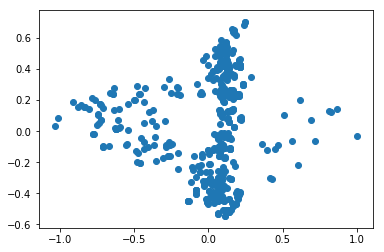

In [15]:
from sklearn.cluster import KMeans
#kmeans = KMeans(init='k-means++',n_clusters=2)
kmeans = KMeans(init='random',n_clusters=2)
kmeans.fit(beer_red)
#Reducción de dimensión
plot = manifold.MDS(n_components=2).fit_transform(beer_red)
X = []
Y = []
for x,y in plot:
    X.append(x)
    Y.append(y)
#Ploteo del cluster
plt.scatter(X,Y)
plt.show()


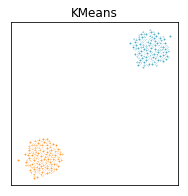

In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets.samples_generator import make_blobs
np.random.seed(0)
centers = [[1,1],[-1,-1]]
X, labels_true = make_blobs(n_samples=10000, centers=centers, cluster_std = 0.1)
from sklearn.cluster import KMeans
k_means = KMeans(init="random", n_clusters=2, n_init=10)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
fig = plt.figure(figsize=(3,3))
colors = ['#4EACC5','#FF9C34','#4E9A06']
ax = fig.add_subplot(1,1,1)
ax.set_title('KMeans')
for k, col in zip(range(3), colors):
	my_members = k_means_labels == k
	ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
	
ax.set_xticks(())
ax.set_yticks(())
plt.show()

**Minibatch K-MEANS**:

Es una variación del algoritmo de K-means que se usa pequeños lotes "mini-batches" de datos para correr k-means cuando la colección de datos es muy grande para que quepa en memoria.

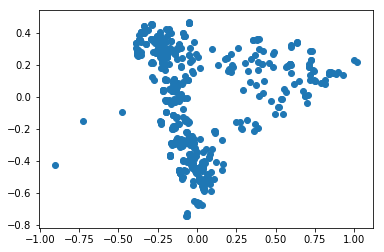

In [17]:
from sklearn.cluster import MiniBatchKMeans
from sklearn import manifold
kmeans = MiniBatchKMeans(init='k-means++',n_clusters=4)
kmeans.fit(beer_red)
#Reducción de dimensión
plot = manifold.MDS(n_components=2).fit_transform(beer_red)
#Ploteo del cluster
X = []
Y = []
for x,y in plot:
    X.append(x)
    Y.append(y)
#Ploteo del cluster
plt.scatter(X,Y)
plt.show()


**HAC Complete**
Hierarchical Agglomerative Clustering

In [20]:
from sklearn import datasets
#digits = datasets.load_digits(n_class=10)
X = beer_reviews.data
y = beer_reviews.target
n_samples, n_features = X.shape
from sklearn import manifold
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
from sklearn.cluster import AgglomerativeClustering as hac
clustering = hac(linkage="complete", n_clusters=10, affinity="euclidean")
clustering.fit(X)
x_min, x_max = numpy.min(X_red, axis=0), numpy.max(X_red, axis=0)
X_red = (X_red - x_min)/(x_max - x_min)
for i in range(X_red.shape[0]):
	plt.text(X_red[i,0], X_red[i,1], str(y[i]),
	color=plt.cm.spectral(clustering.labels_[i]/10.),
	fontdict={'weight': 'bold', 'size': 8})

plt.show()

AttributeError: 'DataFrame' object has no attribute 'data'

**DBSCAN**

In [1]:
import numpy, scipy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = numpy.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)
colors = plt.cm.Spectral(numpy.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
	if k == -1:
		col = 'k'

	class_member_mask = (labels == k)

	xy = X[class_member_mask & core_samples_mask]
	plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
	xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

plt.title("DBSCAN")
plt.show()

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-1-29ce6d8f4786>, line 25)

**Ward**

In [ ]:
TODO/ Mostrar una visualización por cada algoritmo, Realizar ajustes a los parámentros para lograr un buen cluster..JUSTIFICAR PROCEDIMIENTO Y ELECCIÓN DE PARÁMETROS.

Encontrar el atributo que mejor representa el cluster, nombre de cervecería ó tipo de cerveza?